#### This dataset was originally posted in a Kaggle competition titled "House Prices: Advanced Regression Techniques". 
#### We will perform exploratory dataset analysis, feature engineering and try to predict the Sales Prices using Advanced Regression Techniques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
pd.set_option("display.max_columns", None)      #to see all columns of dataframe
from sklearn.ensemble import ExtraTreesRegressor
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import xgboost as xgb

Load the train dataset into pandas dataframe

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df = pd.concat([train,test],axis=0)

### Datasize and characteristics

We will combine the train and test sets to:
* better visualize the data 
* handle missing/null values 
* handle outliers
* feature engineer new columns

There are a total of 2919 entries and 81 columns ->  numeric (38) and non-numeric (43).

In [3]:
print(f"Size of train dataset: {train.shape}")
print(f"Size of test dataset: {test.shape}")

Size of train dataset: (1460, 81)
Size of test dataset: (1459, 80)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [5]:
#number of numeric columns
print("Number of numeric columns:", len(list(df.loc[:,df.dtypes != object].columns)))

#number of non-numeric columns
print("Number of non-numeric columns:", len(list(df.loc[:,df.dtypes == object].columns)))

Number of numeric columns: 38
Number of non-numeric columns: 43


In [6]:
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

### Exploring important variables

#### Target variable: SalePrice

We can see that the distribution is right skewed. This indicates that there are few houses with very high prices

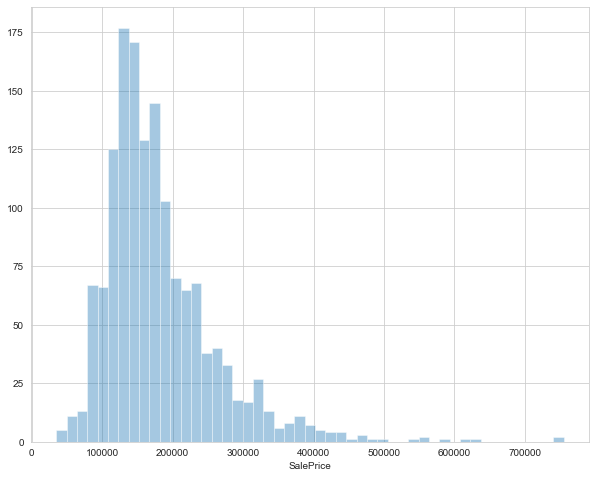

In [7]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,8))
sns.distplot(df[~df['SalePrice'].isna()]['SalePrice'],kde=False)
plt.show()

Let us now get the correlation of columns with SalePrice to identify the most important numeric columns. We will filter out columns with correlation > 0.5, indicating strong positive correlation, and correlation < -0.5, indicating strong negative correlation.

There are about 10 such columns.

In [8]:
corr = df.corr()['SalePrice'][(df.corr()['SalePrice']>0.5) | (df.corr()['SalePrice']<-0.5)].sort_values(ascending=False)
corr

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64

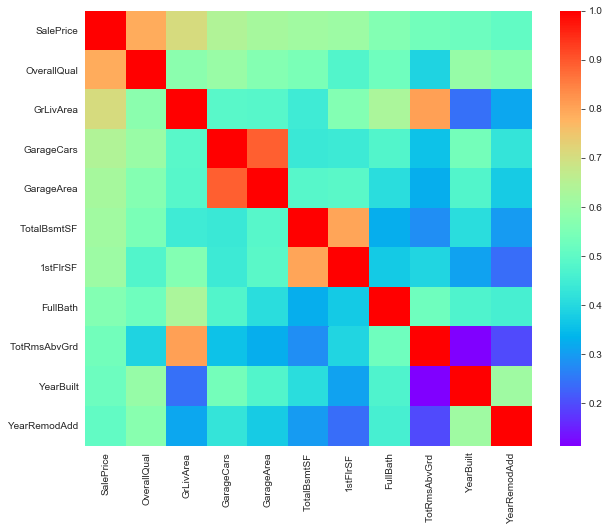

In [9]:
top_numeric_cols = list(corr.index)
fig = plt.figure(figsize=(10,8))
sns.heatmap(df[top_numeric_cols].corr(),cmap='rainbow')

Features **OverallQual** and **GrLivArea** have the highest correlation with SalePrice.

* **OverallQual**: Overall material and finish quality
* **GrLivArea**: Above grade (ground) living area square feet

We will plot their behaviour against SalePrice. 

Also, if we observe closely we can also see the presence of multicollinearity. Eg: GarageCars-GarageArea, 1stFlrSF-TotalBsmtFlrSF, which makes sense because Garage with higher area, will have higher car capacity. We will deal with such type of correlated features later.

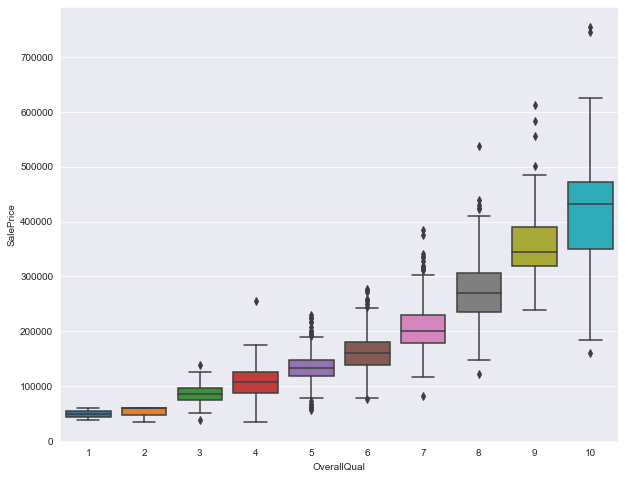

In [10]:
sns.set_style('darkgrid')
fig = plt.figure(figsize=(10,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=df)

There is a clear upward trend visible here

In [11]:
fig = px.scatter(data_frame=df, x='GrLivArea', y='SalePrice',hover_data=['Id'])
fig.show()

For GrLivArea, there is also a clear upward trend visible. However, we can also observe certain outliers - houses with Id 524, and 1299, which despite having big living areas, are cheaper than what one might expect. However we will not remove these houses right now, as there might be other factors contributing to their lower SalePrice which we will explore.

In [12]:
df[df['Id'].isin([524,1299])][['OverallQual']]

OverallQual
523            10
1298           10

The OverallQual of the potential outlier candidates is also really good, which makes them good candidates for outliers. We will make a note of them.

In [13]:
temp_outlier_id = [524, 1299] 

Upon examining the non-numeric columns, we can see that some of the columns are ordinal in nature. We will identify those, and convert them into LabelEncoding later.

### Handle Missing Values

Lets find out columns containing missing values

In [14]:
df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageCond       159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
BsmtFinSF2         1
BsmtUnfSF          1
BsmtFinSF1         1
TotalBsmtSF        1
SaleType           1
KitchenQual        1
Exterior2nd        1
Exterior1st        1
GarageCars         1
GarageArea         1
Electrical         1
dtype: int64

In [15]:
print(f"Number of columns with missing data: {len(df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False))}")

Number of columns with missing data: 35


Also, the SalePrice contains 1459 missing values, which simply correspond to our test dataset entries.

Altogether, we have 34 columns for which we have to handle missing values.

## Imputing Missing Data and Transforming Non-Numeric Features (into Ordinal)

We will fix missing values in descending order of their missing count, but will consider columns of similar category together.

We will also transform non-numeric columns into Ordinal wherever applicable.

#### PoolQC: Pool quality

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

We will impute NA to missing PoolQC rows.

In [16]:
df['PoolQC'].fillna('NA',inplace=True)

As we can see that the values of PoolQC are ordinal in nature, we will map them accordingly.

In [17]:
poolqc_labels = {'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0}
df['PoolQC'] = df['PoolQC'].map(poolqc_labels)
# df.head()['PoolQC']

Simultaneusly, we'll also check another pool variable **PoolArea** (Pool area in square feet) just in case its present for some house, but PoolQC is missing for them.  For such rows, we will replace PoolQC based on OverallQC of the houses.

In [18]:
print("Before conversion:")
print(df[(df['PoolQC']==0) & (df['PoolArea']>0)][['Id','PoolQC','PoolArea','OverallQual']])

Before conversion:
        Id  PoolQC  PoolArea  OverallQual
960   2421       0       368            4
1043  2504       0       444            6
1139  2600       0       561            3


In [19]:
print("After conversion:")
df.loc[df['Id']==2421,'PoolQC'] = 2
df.loc[df['Id']==2504,'PoolQC'] = 3
df.loc[df['Id']==2600,'PoolQC'] = 2
print(df.loc[df['Id'].isin([2421,2504,2600])][['Id','PoolQC','PoolArea','OverallQual']])
print(df[(df['PoolQC']==0) & (df['PoolArea']>0)][['PoolQC','PoolArea','OverallQual']])

After conversion:
        Id  PoolQC  PoolArea  OverallQual
960   2421       2       368            4
1043  2504       3       444            6
1139  2600       2       561            3
Empty DataFrame
Columns: [PoolQC, PoolArea, OverallQual]
Index: []


In [20]:
# add to ordinal feature list
ordinal_features = []
ordinal_features.append('PoolQC')

#### MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	  None
       
We will replace missing values with 'NA'

In [21]:
df['MiscFeature'].fillna('NA',inplace=True)

Lets plot the frequencies of MiscFeature vs Median SalePrice, to get an idea about the distribution and correlation

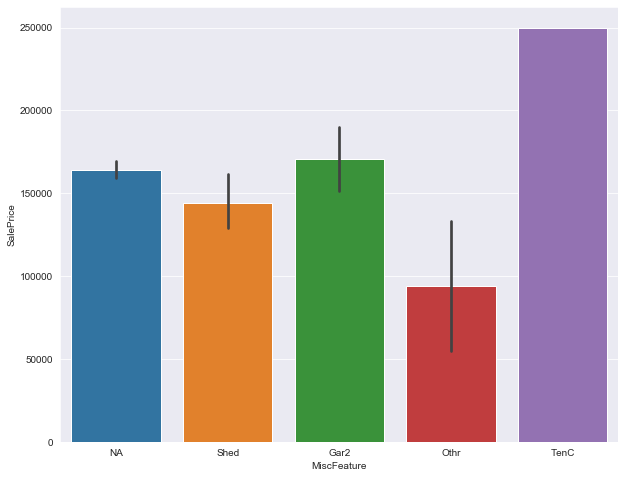

In [22]:
fig = plt.figure(figsize=(10,8))
sns.barplot(x='MiscFeature', y='SalePrice', data=df, estimator=np.median)
# sns.violinplot(x='MiscFeature', y='SalePrice', data=df)
# px.bar(data,'MiscFeature','SalePrice',)
# sns.catplot(x='MiscFeature', y='SalePrice', data=df)
# sns.countplot(x='MiscFeature', data=df)

In [23]:
df['MiscFeature'].value_counts()

NA      2814
Shed      95
Gar2       5
Othr       4
TenC       1
Name: MiscFeature, dtype: int64

This feature does not seem to have much significance.

In [24]:
df['MiscFeature'].isna().sum()

0

#### Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

We will impute missing values with NA

In [25]:
df['Alley'].isna().sum()

2721

In [26]:
df['Alley'].fillna('NA',inplace=True)

In [27]:
df['Alley'].value_counts()

NA      2721
Grvl     120
Pave      78
Name: Alley, dtype: int64

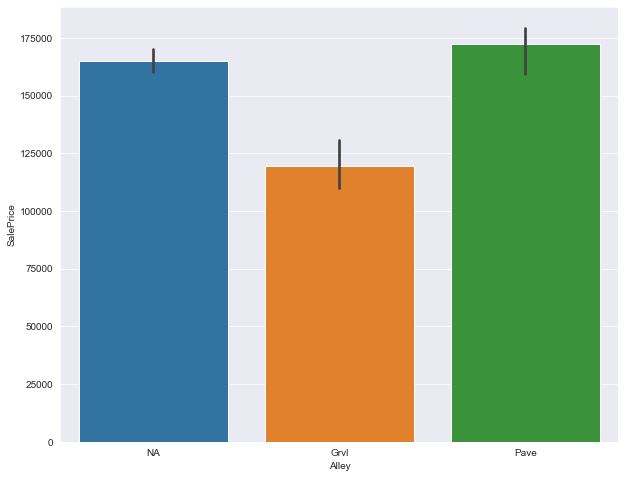

In [28]:
fig = plt.figure(figsize=(10,8))
sns.barplot(x='Alley', y='SalePrice', data=df, estimator=np.median)

#### Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo     Good Wood
       MnWw	 Minimum Wood/Wire
       NA	   No Fence
       
Impute missing values with 'NA'. Can be transformed to ordinal values.

In [29]:
print(f"Number of missing values in Fence: {df['Fence'].isna().sum()}")

Number of missing values in Fence: 2348


In [30]:
df['Fence'].fillna('NA', inplace=True)

In [31]:
df['SalePrice'].groupby(df['Fence']).median()

Fence
GdPrv    167500.0
GdWo     138750.0
MnPrv    137450.0
MnWw     130000.0
NA       173000.0
Name: SalePrice, dtype: float64

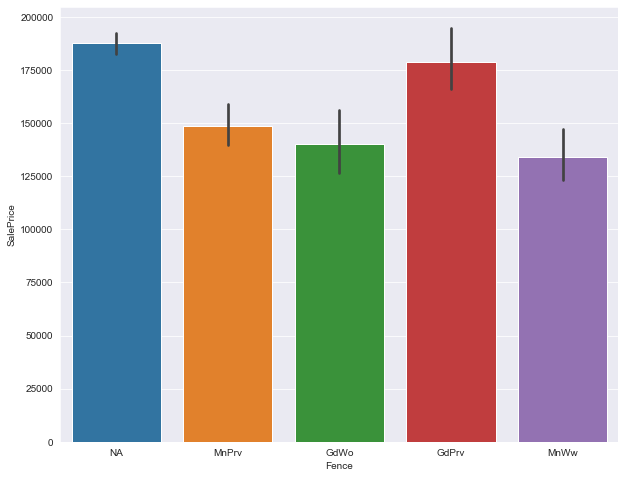

In [32]:
fig = plt.figure(figsize=(10,8))
sns.barplot(x='Fence', y='SalePrice', data=df)

The median SalePrice distribution does not give any indication of Fence having an ordinality to it. 

#### FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [33]:
print(f"Number of missing values in FireplaceQu: {df['FireplaceQu'].isna().sum()}")

Number of missing values in FireplaceQu: 1420


In [34]:
df['FireplaceQu'].fillna('NA', inplace=True)

In [35]:
FireplaceQu_labels = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['FireplaceQu'] = df['FireplaceQu'].map(FireplaceQu_labels)

In [36]:
df['FireplaceQu'].value_counts()

0    1420
4     744
3     592
2      74
1      46
5      43
Name: FireplaceQu, dtype: int64

In [37]:
# add to ordinal feature list
ordinal_features.append('FireplaceQu')

#### LotFrontage: Linear feet of street connected to property

In [38]:
print(f"Number of missing values in LotFrontage: {df['LotFrontage'].isna().sum()}")

Number of missing values in LotFrontage: 486


We can impute the missing values by taking median of LotFrontage grouped by Neighbourhood, assuming that houses in same neighbourhood have similar LotFrontage

Text(0, 0.5, 'Lot Frontage')

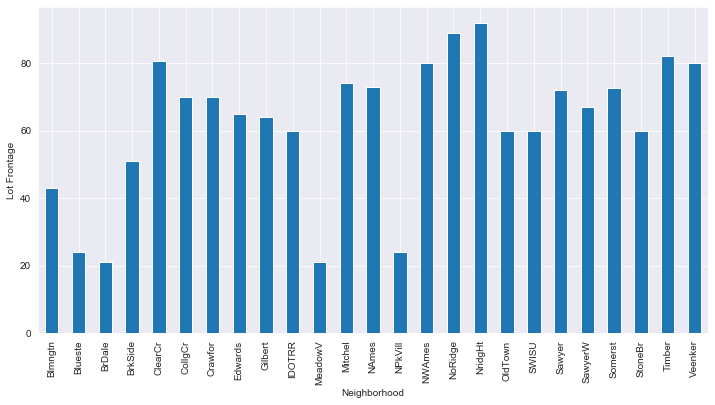

In [39]:
fig = plt.figure(figsize=(12,6))
df['LotFrontage'].groupby(df['Neighborhood']).median().plot(kind='bar')
plt.ylabel('Lot Frontage')

In [40]:
df['LotFrontage'] = df['LotFrontage'].fillna(df.groupby('Neighborhood')['LotFrontage'].transform('median'))

#### LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular
       
Features seem ordinal, so we will convert accordingly, with IR3 (Irregular) being the worst and Reg (Regular) being the best

In [41]:
LotShape_labels = {'IR3':0, 'IR2':1, 'IR1':2, 'Reg':3}
df['LotShape'] = df['LotShape'].map(LotShape_labels)

In [42]:
# add to ordinal feature list
ordinal_features.append('LotShape')

#### GarageYrBlt: Year garage was built

We will impute missing values with YearBuilt (Original construction date)

In [43]:
print(f"Number of missing values in GarageYrBlt: {df['GarageYrBlt'].isna().sum()}")
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
print(f"Number of missing values in GarageYrBlt: {df['GarageYrBlt'].isna().sum()}")

Number of missing values in GarageYrBlt: 159
Number of missing values in GarageYrBlt: 0


#### GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Garage) being the worst and Fin (Finished) being the best

In [44]:
print(f"Number of missing values in GarageFinish: {df['GarageFinish'].isna().sum()}")

Number of missing values in GarageFinish: 159


In [45]:
df['GarageFinish'].fillna('NA', inplace=True)

In [46]:
GarageFinish_labels = {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}
df['GarageFinish'] = df['GarageFinish'].map(GarageFinish_labels)

In [47]:
# add to ordinal feature list
ordinal_features.append('GarageFinish')

#### GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Garage) being the worst and Ex (Excellent) being the best

In [48]:
print(f"Number of missing values in GarageQual: {df['GarageQual'].isna().sum()}")

Number of missing values in GarageQual: 159


In [49]:
df['GarageQual'].fillna('NA', inplace=True)

In [50]:
GarageQual_labels = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['GarageQual'] = df['GarageQual'].map(GarageQual_labels)

In [51]:
# add to ordinal feature list
ordinal_features.append('GarageQual')

#### GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Garage) being the worst and Ex (Excellent) being the best

In [52]:
print(f"Number of missing values in GarageCond: {df['GarageCond'].isna().sum()}")

Number of missing values in GarageCond: 159


In [53]:
df['GarageCond'].fillna('NA', inplace=True)

In [54]:
GarageCond_labels = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['GarageCond'] = df['GarageCond'].map(GarageCond_labels)

In [55]:
# add to ordinal feature list
ordinal_features.append('GarageCond')

#### GarageType: Garage location
		
       2Types	 More than one type of garage
       Attchd	 Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	 Detached from home
       NA	     No Garage
       
We will impute missing values with NA.

Features do not seem ordinal, we will leave as it is

In [56]:
print(f"Number of missing values in GarageType: {df['GarageType'].isna().sum()}")

Number of missing values in GarageType: 157


In [57]:
df['GarageType'].fillna('NA', inplace=True)

**There seems to be a discrepancy in the number of NA (No Garage) for features GarageType (157), and other Garage Features (157) each - GarageFinish, GarageQual, GarageCond. Lets explore that.**

In [58]:
len(df[(df['GarageFinish']==0) & (df['GarageQual']==0) & (df['GarageCond']==0)])

159

The 159 No Garage values for features GarageFinish, GarageQual, GarageCond are the same rows. Lets see where the difference lies wrt GarageType

In [59]:
df[(df['GarageFinish']==0) & (df['GarageType']!='NA')][['Id','GarageType','GarageCars','GarageArea','GarageFinish','GarageQual','GarageCond']]

Id GarageType  GarageCars  GarageArea  GarageFinish  GarageQual  \
666   2127     Detchd         1.0       360.0             0           0   
1116  2577     Detchd         NaN         NaN             0           0   

      GarageCond  
666            0  
1116           0

For House 2127, data exists for GarageCars and GarageArea, which means its GarageFinish, GarageQual and GarageCond have been incorrectly labelled as missing. We will replace them with the modes of their respective features

In [60]:
df.loc[df['Id']==2127,'GarageFinish'] = df['GarageFinish'].mode()[0]
df.loc[df['Id']==2127,'GarageQual'] = df['GarageQual'].mode()[0]
df.loc[df['Id']==2127,'GarageCond'] = df['GarageCond'].mode()[0]

For House 2577, all its values correspond to having no garage, other than GarageType (='Detchd'). So we will fix that alongwith missing values for other columns

In [61]:
df.loc[df['Id']==2577,'GarageType'] = 'NA'
df.loc[df['Id']==2577,'GarageCars'] = 0
df.loc[df['Id']==2577,'GarageArea'] = 0

In [62]:
df[df['Id'].isin([2127,2577])][['Id','GarageType','GarageCars','GarageArea','GarageFinish','GarageQual','GarageCond']]

Id GarageType  GarageCars  GarageArea  GarageFinish  GarageQual  \
666   2127     Detchd         1.0       360.0             1           3   
1116  2577         NA         0.0         0.0             0           0   

      GarageCond  
666            3  
1116           0

NA values for all Garage features must now be equal to 158.

In [63]:
len(df[(df['GarageFinish']==0) & (df['GarageQual']==0) & (df['GarageCond']==0) & (df['GarageType']=='NA')])

158

There should be no missing values remaining for Garage features as well.

In [64]:
df[['GarageType','GarageCars','GarageArea','GarageFinish','GarageQual','GarageCond','GarageYrBlt']].isna().sum()

GarageType      0
GarageCars      0
GarageArea      0
GarageFinish    0
GarageQual      0
GarageCond      0
GarageYrBlt     0
dtype: int64

For all Basement features, we can observe discrepancies in their null value count. We will anaylze them as we move ahead.

In [65]:
df[['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1',
    'BsmtFullBath','BsmtHalfBath','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1','TotalBsmtSF']].isna().sum()

BsmtCond        82
BsmtExposure    82
BsmtQual        81
BsmtFinType2    80
BsmtFinType1    79
BsmtFullBath     2
BsmtHalfBath     2
BsmtFinSF2       1
BsmtUnfSF        1
BsmtFinSF1       1
TotalBsmtSF      1
dtype: int64

#### BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Basement) being the worst and Ex (Excellent) being the best

In [66]:
print(f"Number of missing values in BsmtCond: {df['BsmtCond'].isna().sum()}")

Number of missing values in BsmtCond: 82


In [67]:
df['BsmtCond'].fillna('NA',inplace=True)
BsmtCond_labels = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['BsmtCond'] = df['BsmtCond'].map(BsmtCond_labels)

In [68]:
# add to ordinal feature list
ordinal_features.append('BsmtCond')

#### BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Basement) being the worst and Gd (Good Exposure) being the best

In [69]:
print(f"Number of missing values in BsmtExposure: {df['BsmtExposure'].isna().sum()}")

Number of missing values in BsmtExposure: 82


In [70]:
df['BsmtExposure'].fillna('NA',inplace=True)
BsmtExposure_labels = {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4}
df['BsmtExposure'] = df['BsmtExposure'].map(BsmtExposure_labels)

In [71]:
# add to ordinal feature list
ordinal_features.append('BsmtExposure')

#### BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Basement) being the worst and Ex (Excellent) being the best

In [72]:
print(f"Number of missing values in BsmtQual: {df['BsmtQual'].isna().sum()}")

Number of missing values in BsmtQual: 81


In [73]:
df['BsmtQual'].fillna('NA',inplace=True)
BsmtQual_labels = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['BsmtQual'] = df['BsmtQual'].map(BsmtQual_labels)

In [74]:
# add to ordinal feature list
ordinal_features.append('BsmtQual')

#### BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Basement) being the worst and GLQ (Good Living Quarters) being the best

In [75]:
print(f"Number of missing values in BsmtFinType1: {df['BsmtFinType1'].isna().sum()}")

Number of missing values in BsmtFinType1: 79


In [76]:
df['BsmtFinType1'].fillna('NA',inplace=True)
BsmtFinType1_labels = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
df['BsmtFinType1'] = df['BsmtFinType1'].map(BsmtFinType1_labels)

In [77]:
# add to ordinal feature list
ordinal_features.append('BsmtFinType1')

#### BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
       
We will impute missing values with NA.

Features seem ordinal, so we will convert accordingly, with NA (No Basement) being the worst and GLQ (Good Living Quarters) being the best

In [78]:
print(f"Number of missing values in BsmtFinType2: {df['BsmtFinType2'].isna().sum()}")

Number of missing values in BsmtFinType2: 80


In [79]:
df['BsmtFinType2'].fillna('NA',inplace=True)
BsmtFinType2_labels = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
df['BsmtFinType2'] = df['BsmtFinType2'].map(BsmtFinType2_labels)

In [80]:
# add to ordinal feature list
ordinal_features.append('BsmtFinType2')

Since features BsmtCond, BsmtExposure, BsmtQual, BsmtFinType2, BsmtFinType1 have NA values in 79-82 range, we will first check whether the 79 values correspond to the same rows, and check out the discrepancy in the remaining 3 rows.

In [81]:
len(df[(df['BsmtCond']==0) | (df['BsmtExposure']==0) | (df['BsmtQual']==0) | (df['BsmtFinType2']==0) | (df['BsmtFinType1']==0)])

88

In [82]:
df[(df['BsmtFinType1']!=0) & ((df['BsmtCond']==0) | (df['BsmtExposure']==0) | (df['BsmtQual']==0) | (df['BsmtFinType2']==0))][['Id',
'BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1',
'BsmtFullBath','BsmtHalfBath','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1','TotalBsmtSF']]

Id  BsmtCond  BsmtExposure  BsmtQual  BsmtFinType2  BsmtFinType1  \
332    333         3             1         4             0             6   
948    949         3             0         4             1             1   
27    1488         3             0         4             1             1   
580   2041         0             2         4             3             6   
725   2186         0             1         3             1             4   
757   2218         2             1         0             1             1   
758   2219         3             1         0             1             1   
888   2349         3             0         4             1             1   
1064  2525         0             3         3             1             5   

      BsmtFullBath  BsmtHalfBath  BsmtFinSF2  BsmtUnfSF  BsmtFinSF1  \
332            1.0           0.0       479.0     1603.0      1124.0   
948            0.0           0.0         0.0      936.0         0.0   
27             0.0           0.0         0.0     1595.0         0.0   
580            1.0           0.0       382.0        0.0      1044.0   
725            0.0           1.0         0.0       94.0      1033.0   
757            0.0           0.0         0.0      173.0         0.0   
758            0.0           0.0         0.0      356.0         0.0   
888            0.0           0.0         0.0      725.0         0.0   
1064           0.0           0.0         0.0      240.0       755.0   

      TotalBsmtSF  
332        3206.0  
948         936.0  
27         1595.0  
580        1426.0  
725        1127.0  
757         173.0  
758         356.0  
888         725.0  
1064        995.0

All in all, it seems that 79 houses are without basement, and the remaining houses have one missing basement feature, which we will replace by mode of that feature.

In [83]:
df.loc[df['Id']==333,'BsmtFinType2'] = df['BsmtFinType2'].mode()[0]
df.loc[df['Id'].isin([949, 1488, 2349]),'BsmtExposure'] = df['BsmtExposure'].mode()[0]
df.loc[df['Id'].isin([2041, 2186, 2525]),'BsmtCond'] = df['BsmtCond'].mode()[0]
df.loc[df['Id'].isin([2218, 2219]),'BsmtQual'] = df['BsmtQual'].mode()[0]

Lets fix remaining basement variables having 1-2 missing values.
* **BsmtFinSF1**: Type 1 finished square feet
* **BsmtFinSF2**: Type 2 finished square feet
* **BsmtUnfSF**: Unfinished square feet of basement area
* **TotalBsmtSF**: Total square feet of basement area
* **BsmtFullBath**: Basement full bathrooms
* **BsmtHalfBath**: Basement half bathrooms

In [84]:
df[(df['BsmtFinSF1'].isna()) | (df['BsmtFinSF2'].isna()) | (df['BsmtUnfSF'].isna()) | (df['TotalBsmtSF'].isna()) |
   (df['BsmtFullBath'].isna()) | (df['BsmtHalfBath'].isna())][['Id','BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2',
'BsmtFinType1', 'BsmtFullBath','BsmtHalfBath','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1','TotalBsmtSF']]

Id  BsmtCond  BsmtExposure  BsmtQual  BsmtFinType2  BsmtFinType1  \
660  2121         0             0         0             0             0   
728  2189         0             0         0             0             0   

     BsmtFullBath  BsmtHalfBath  BsmtFinSF2  BsmtUnfSF  BsmtFinSF1  \
660           NaN           NaN         NaN        NaN         NaN   
728           NaN           NaN         0.0        0.0         0.0   

     TotalBsmtSF  
660          NaN  
728          0.0

As these features are numerical, and correspond to houses not having any basement, we will impute these values with 0.

In [85]:
df['BsmtFinSF1'].fillna(0, inplace=True)
df['BsmtFinSF2'].fillna(0, inplace=True)
df['BsmtUnfSF'].fillna(0, inplace=True)
df['TotalBsmtSF'].fillna(0, inplace=True)
df['BsmtFullBath'].fillna(0, inplace=True)
df['BsmtHalfBath'].fillna(0, inplace=True)

In [86]:
df[['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1',
    'BsmtFullBath','BsmtHalfBath','BsmtFinSF2','BsmtUnfSF','BsmtFinSF1','TotalBsmtSF']].isna().sum()

BsmtCond        0
BsmtExposure    0
BsmtQual        0
BsmtFinType2    0
BsmtFinType1    0
BsmtFullBath    0
BsmtHalfBath    0
BsmtFinSF2      0
BsmtUnfSF       0
BsmtFinSF1      0
TotalBsmtSF     0
dtype: int64

All basement features having missing values are now fixed.

#### MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
       
#### MasVnrArea: Masonry veneer area in square feet

In [87]:
df[['MasVnrType','MasVnrArea']].isna().sum()

MasVnrType    24
MasVnrArea    23
dtype: int64

In [88]:
len(df[(df['MasVnrType'].isna()) & (df['MasVnrArea'].isna())])

23

We can see that the 23 rows actually correspond to MasVnrType as None, and 1 row (Id=2611) has value for MasVnrArea. We will impute MasVnrType for that row as the mode of that column. And for remaining rows, will impute MasVnrType as None, and MasVnrArea as 0.

In [89]:
df[(df['MasVnrType'].isna()) & (~df['MasVnrArea'].isna())][['Id','MasVnrType','MasVnrArea']]

Id MasVnrType  MasVnrArea
1150  2611        NaN       198.0

In [90]:
df.loc[df['Id']==2611,'MasVnrType'] = df['MasVnrType'].mode()[0]
df['MasVnrType'].fillna('None', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)

In [91]:
df[['MasVnrType','MasVnrArea']].isna().sum()

MasVnrType    0
MasVnrArea    0
dtype: int64

On first glance, it seems that the values for MasVnrType as nominal. Lets explore their relationship with SalePrice to identify if there's any ordinality present or not.

In [92]:
mason = pd.DataFrame(df.groupby('MasVnrType')['SalePrice'].median())
mason['counts'] = df['MasVnrType'].value_counts()
mason.reset_index(inplace=True)
mason.sort_values('SalePrice')

MasVnrType  SalePrice  counts
0     BrkCmn   139000.0      25
2       None   143125.0    1766
1    BrkFace   181000.0     879
3      Stone   246839.0     249

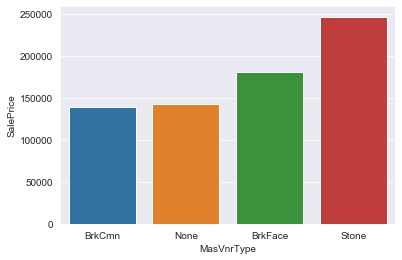

In [93]:
sns.barplot(x='MasVnrType',y='SalePrice', data=mason, order=mason.sort_values('SalePrice')['MasVnrType'])

There is a notable difference in median SalePrice of MasVnrType = Brick Common/None and that of Brick Face, Stone. We will give the order accordingly.

In [94]:
MasVnrType_labels = {'BrkCmn':0, 'None':0, 'BrkFace':1, 'Stone':2}
df['MasVnrType'] = df['MasVnrType'].map(MasVnrType_labels)

In [95]:
# add to ordinal feature list
ordinal_features.append('MasVnrType')

#### MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
       
Seems to be a categorical variable with no inherent ordinality. We will explore it further.

In [96]:
mszone = pd.DataFrame(df.groupby('MSZoning')['SalePrice'].median())
mszone['counts'] = df['MSZoning'].value_counts()
mszone.reset_index(inplace=True)
mszone.sort_values('SalePrice')

MSZoning  SalePrice  counts
0  C (all)    74700.0      25
4       RM   120500.0     460
2       RH   136500.0      26
3       RL   174000.0    2265
1       FV   205950.0     139

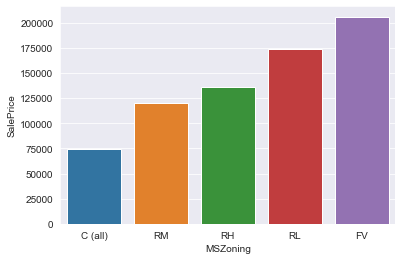

In [97]:
sns.barplot(x='MSZoning',y='SalePrice', data=mszone, order=mszone.sort_values('SalePrice')['MSZoning'])

There appears to be a certain pattern, but the description of the column consists of more features types which are not present in the data (A, I, RP). We will consider this column as nominal only, and impute missing values as the mode.



In [98]:
df['MSZoning'].fillna(df['MSZoning'].mode()[0],inplace=True)

#### Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
       
We will impute missing values with mode of the column.

Features seem ordinal by description. so we will convert accordingly, with Sal (Salvage only) being the worst and Typ (Typical Functionality) being the best     

In [99]:
print(f"Number of missing values in Functional: {df['Functional'].isna().sum()}")

Number of missing values in Functional: 2


In [100]:
df['Functional'].fillna(df['Functional'].mode()[0], inplace=True)
Functional_labels = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
df['Functional'] = df['Functional'].map(Functional_labels)

In [101]:
# add to ordinal feature list
ordinal_features.append('Functional')

#### Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only
       
We will impute missing values with mode of the column.

Features seem ordinal by description. so we can convert accordingly, with ELO (Electricity only) being the worst and AllPub (All public Utilities (E,G,W,& S)) being the best   

In [102]:
print(f"Number of missing values in Utilities: {df['Utilities'].isna().sum()}")

Number of missing values in Utilities: 2


In [103]:
print('Train value counts:')
print(train['Utilities'].value_counts())
print('\nTest value counts:')
print(test['Utilities'].value_counts())

Train value counts:
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

Test value counts:
AllPub    1457
Name: Utilities, dtype: int64


As seen above, the only missing values are present in test set, and if we impute them with mode value, then all data will be equal to AllPub. This makes the column effectively useless. So we will drop it.

In [104]:
df.drop(columns=['Utilities'],inplace=True)

#### SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
       
Values are categorical. No ordinality visible as per description. Mode value to be imputed.

In [105]:
print(f"Number of missing values in SaleType: {df['SaleType'].isna().sum()}")

Number of missing values in SaleType: 1


In [106]:
df['SaleType'].fillna(df['SaleType'].mode()[0], inplace=True)

#### KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       
We will impute missing values with mode of the column.

Features seem ordinal by description. So we can convert accordingly, with Po (Poor) being the worst and Ex (Excellent) being the best   

In [107]:
print(f"Number of missing values in KitchenQual: {df['KitchenQual'].isna().sum()}")

Number of missing values in KitchenQual: 1


In [108]:
df['KitchenQual'].fillna(df['KitchenQual'].mode()[0], inplace=True)

In [109]:
KitchenQual_labels = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
df['KitchenQual'] = df['KitchenQual'].map(KitchenQual_labels)

In [110]:
# add to ordinal feature list
ordinal_features.append('KitchenQual')

#### Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Values are categorical. No ordinality visible as per description. Mode value to be imputed.

In [111]:
print(f"Number of missing values in Exterior1st: {df['Exterior1st'].isna().sum()}")

Number of missing values in Exterior1st: 1


In [112]:
df['Exterior1st'].fillna(df['Exterior1st'].mode()[0], inplace=True)

#### Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
       
Values are categorical. No ordinality visible as per description. Mode value to be imputed.

In [113]:
print(f"Number of missing values in Exterior2nd: {df['Exterior2nd'].isna().sum()}")

Number of missing values in Exterior2nd: 1


In [114]:
df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0], inplace=True)

#### Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
       
Values are categorical. No ordinality visible as per description. Mode value to be imputed.

In [115]:
print(f"Number of missing values in Electrical: {df['Electrical'].isna().sum()}")

Number of missing values in Electrical: 1


In [116]:
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

#### At this point, we have dealt with all missing values in our dataset. (The 1459 missing values just correspond to the test set)

We will evaluate remaining categorical columns to see if there is any ordinality in their values.

In [117]:
df.isna().sum()[df.isna().sum()>0]

SalePrice    1459
dtype: int64

#### ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
Features seem ordinal by description. So we can convert accordingly, with Po (Poor) being the worst and Ex (Excellent) being the best.

In [118]:
ExterQual_labels = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
df['ExterQual'] = df['ExterQual'].map(ExterQual_labels)

In [119]:
# add to ordinal feature list
ordinal_features.append('ExterQual')

#### ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
Features seem ordinal by description. So we can convert accordingly, with Po (Poor) being the worst and Ex (Excellent) being the best.

In [120]:
ExterCond_labels = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
df['ExterCond'] = df['ExterCond'].map(ExterCond_labels)

In [121]:
# add to ordinal feature list
ordinal_features.append('ExterCond')

#### BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
       
Seems ordinal by description, however the relationship with SalePrice does not give any justify the assumpton. Hence, we'll keep it categorical.

In [122]:
BldgType = pd.DataFrame(df.groupby('BldgType')['SalePrice'].median())
BldgType['counts'] = df['BldgType'].value_counts()
BldgType.reset_index(inplace=True)
BldgType.sort_values('SalePrice')

BldgType  SalePrice  counts
1   2fmCon   127500.0      62
2   Duplex   135980.0     109
3    Twnhs   137500.0      96
0     1Fam   167900.0    2425
4   TwnhsE   172200.0     227

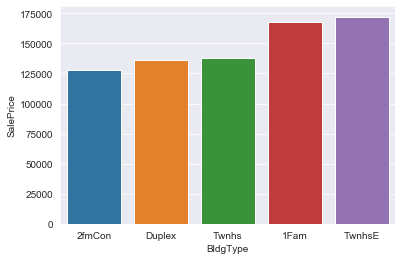

In [123]:
sns.barplot(x='BldgType',y='SalePrice', data=BldgType, order=BldgType.sort_values('SalePrice')['BldgType'])

#### CentralAir: Central air conditioning

       N	No
       Y	Yes
       
Ordinal

In [124]:
CentralAir_labels = {'N':0, 'Y':1}
df['CentralAir'] = df['CentralAir'].map(CentralAir_labels)

In [125]:
# add to ordinal feature list
ordinal_features.append('CentralAir')

#### HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor
       
Features seem ordinal by description. So we can convert accordingly, with Po (Poor) being the worst and Ex (Excellent) being the best.

In [126]:
HeatingQC_labels = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
df['HeatingQC'] = df['HeatingQC'].map(HeatingQC_labels)

In [127]:
# add to ordinal feature list
ordinal_features.append('HeatingQC')

#### LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope
       
Features seem ordinal by description. So we can convert accordingly, with Sev (Severe Slope) being the worst and Gtl (Gentle slope) being the best.

In [128]:
LandSlope_labels = {'Sev':0, 'Mod':1, 'Gtl':2}
df['LandSlope'] = df['LandSlope'].map(LandSlope_labels)

In [129]:
# add to ordinal feature list
ordinal_features.append('LandSlope')

#### PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
       
Features seem ordinal by description. So we can convert accordingly, with N (Dirt/Gravel) being the worst and Y (Paved) being the best.

In [130]:
PavedDrive_labels = {'N':0, 'P':1, 'Y':2}
df['PavedDrive'] = df['PavedDrive'].map(PavedDrive_labels)

In [131]:
# add to ordinal feature list
ordinal_features.append('PavedDrive')

#### GarageYrBlt: Year garage was built
There appears to be an incorrect value in one of the rows. We will replace it with the most appropriate value

In [132]:
print(df[df['GarageYrBlt']>2020][['Id','GarageYrBlt']])

        Id  GarageYrBlt
1132  2593       2207.0


In [133]:
df.loc[df['Id']==2593, 'GarageYrBlt'] = 2007

## Transform numeric data into categorical

At this point, all possibly ordinal columns have been transformed from categorical to ordinal(numeric). However, there are few numerical columns which are actually categorical in nature. We will look at such columns now.

#### MoSold: Month Sold (MM)
Although June (6) comes after January (1), it does not mean that January is 'better' than June. 

In [134]:
df['MoSold'] = df['MoSold'].apply(lambda x: str(x))

#### MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
       
The numeric values ae just encodings for the longer description. Hence we'll transform this column as well.

In [135]:
df['MSSubClass'] = df['MSSubClass'].apply(lambda x: str(x))

## Feature Engineering

We will create new columns based on existing columns, and check if they add some positive information to our data.

### Total Bathrooms
 = FullBath + (HalfBath * 0.5) + BsmtFullBath + (BsmtHalfBath * 0.5)

In [136]:
df['TotalBtrm'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']

In [137]:
px.scatter(df, x='TotalBtrm', y='SalePrice',trendline='ols',trendline_color_override='black',hover_data=['Id'])

In [138]:
df[['TotalBtrm','FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', 'SalePrice']].corr()

TotalBtrm  FullBath  HalfBath  BsmtFullBath  BsmtHalfBath  \
TotalBtrm      1.000000  0.713269  0.388482      0.602525      0.005015   
FullBath       0.713269  1.000000  0.158386     -0.019224     -0.047117   
HalfBath       0.388482  0.158386  1.000000     -0.033582     -0.058457   
BsmtFullBath   0.602525 -0.019224 -0.033582      1.000000     -0.148655   
BsmtHalfBath   0.005015 -0.047117 -0.058457     -0.148655      1.000000   
SalePrice      0.631731  0.560664  0.284108      0.227122     -0.016844   

              SalePrice  
TotalBtrm      0.631731  
FullBath       0.560664  
HalfBath       0.284108  
BsmtFullBath   0.227122  
BsmtHalfBath  -0.016844  
SalePrice      1.000000

As seen above, Total Bathroom has a higher correlation with SalePrice than any individual component. 

### House Age, IsRemodelled, IsNew
* **House Age** = YrSold {Year Sold (YYYY)} - YearRemodAdd {Remodel date (same as construction date if no remodeling or additions)} 
* **IsRemodelled** = if YearRemodAdd==YearBuilt, then 0, else 1
    
    This can be considered as a penalty that indicates that if the Age of the house is based on a Remodelled date, its worth less than that those houses which were built as new.
* **IsNew** = if YrSold==YearBuilt, then 1, else 0

In [139]:
df['Age'] = df['YrSold'] - df['YearRemodAdd']
df['IsRemodelled'] = np.where(df['YearRemodAdd']==df['YearBuilt'], 0, 1)
df['IsNew'] = np.where(df['YrSold']==df['YearBuilt'], 1, 0)

In [140]:
df.head()[['YearBuilt','YearRemodAdd','YrSold','Age','IsRemodelled','IsNew']]

YearBuilt  YearRemodAdd  YrSold  Age  IsRemodelled  IsNew
0       2003          2003    2008    5             0      0
1       1976          1976    2007   31             0      0
2       2001          2002    2008    6             1      0
3       1915          1970    2006   36             1      0
4       2000          2000    2008    8             0      0

In [141]:
px.scatter(df, x='Age', y='SalePrice',trendline='ols',trendline_color_override='black',hover_data=['Id'])

As expected, the SalePrice goes down with increase in Age of the house

In [142]:
# Drop YearSold as we have added a better feature Age 
df.drop(columns=['YrSold'], inplace=True)

# add to ordinal feature list
ordinal_features.append('IsRemodelled')
ordinal_features.append('IsNew')

### Total Square Feet
= GrLivArea + TotalBsmtSF

In [143]:
df['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']

In [144]:
df[['TotalSF','GrLivArea','TotalBsmtSF','SalePrice']].corr()

TotalSF  GrLivArea  TotalBsmtSF  SalePrice
TotalSF      1.000000   0.871770     0.827118   0.778959
GrLivArea    0.871770   1.000000     0.445710   0.708624
TotalBsmtSF  0.827118   0.445710     1.000000   0.613581
SalePrice    0.778959   0.708624     0.613581   1.000000

As seen above, Total Square Feet has a higher correlation with SalePrice than its individual components.

In [145]:
px.scatter(df, x='TotalSF', y='SalePrice',trendline='ols',trendline_color_override='black',hover_data=['Id'])

The outliers (Id= 524, 1299) are more prominent here. The correlation also improves substantially upon excluding them. We will definitely remove them at a later stage.

In [146]:
print(f"Correlation outliers: {round(df.corr()['SalePrice']['TotalSF'],3)}")
print(f"Correlation without outliers: {round(df[~df['Id'].isin([524,1299])].corr()['SalePrice']['TotalSF'],3)}")

Correlation outliers: 0.779
Correlation without outliers: 0.829


### Binning Neighborhood

Since the neighborhood values are many (25), we will try and bin them into justifiable categories

In [147]:
df['Neighborhood'].nunique()

25

In [148]:
px.histogram(data_frame=df, x='Neighborhood',y='SalePrice', histfunc='avg').update_xaxes(categoryorder='total ascending')

We can see roughly 4 clusters on grouping neighbourhoods by SalePrice. We will bin them accordingly in ordinal manner.

In [149]:
df.loc[df['Neighborhood'].isin(['MeadowV', 'IDOTRR', 'BrDale']),'Nbrhd_category'] = 0
df.loc[df['Neighborhood'].isin(['BrkSide', 'Edwards', 'OldTown', 'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel']),'Nbrhd_category'] = 1
df.loc[df['Neighborhood'].isin(['SawyerW', 'NWAmes', 'Gilbert', 'Blmngtn', 'CollgCr','Crawfor','ClearCr', 'Somerst', 'Veenker', 'Timber']),'Nbrhd_category'] = 2
df.loc[df['Neighborhood'].isin(['StoneBr', 'NridgHt', 'NoRidge']),'Nbrhd_category'] = 3

In [150]:
df.corr()['SalePrice']['Nbrhd_category']

0.6984076996891745

Binning Neighbourhood has resulted in a column with a strong correlation with SalePrice

In [151]:
px.scatter(df, x='Nbrhd_category', y='SalePrice',trendline='ols',trendline_color_override='black',hover_data=['Id'])

In [152]:
# add to ordinal feature list
ordinal_features.append('Nbrhd_category')

## Preparing Data for Modeling

### Remove Outliers

In [153]:
df = df[~df['Id'].isin([524,1299])].reset_index(drop=True)
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index).reset_index(drop=True)
df = df.drop(df[(df['GarageArea']>1200) & (df['SalePrice']<500000)].index).reset_index(drop=True)
# df = df.drop(df[(df['Bsmt']>3000) & (df['SalePrice']<700000)].index).reset_index(drop=True)

Lets perform correlation again. We can see that the number of columns with strong correlation with SalePrice has doubled to 20.

In [154]:
corr = df.corr().abs()['SalePrice'][(df.corr()['SalePrice']>0.5)].sort_values(ascending=False)
len(corr)

20

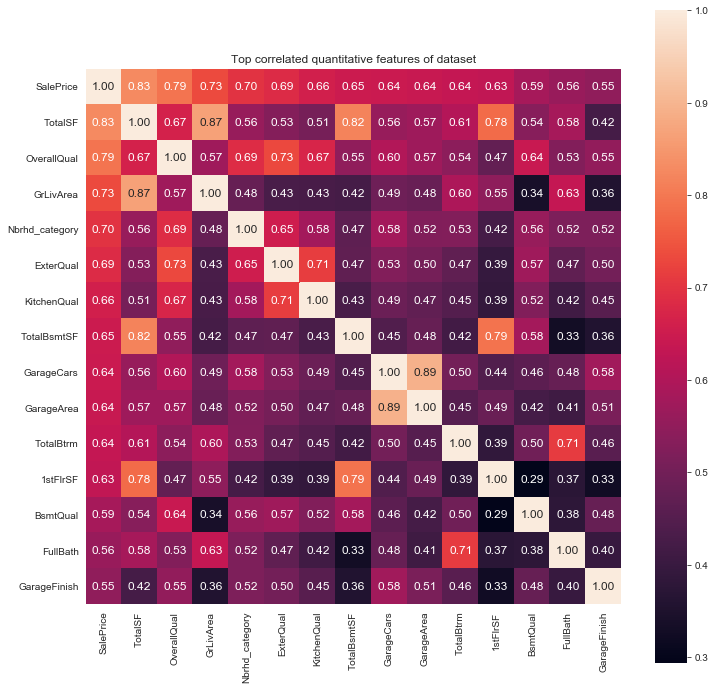

In [155]:
top = 15
corr = df.corr()
top10 = corr.nlargest(top,'SalePrice')['SalePrice'].index
corr_top10 = df[top10].corr()
f,ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_top10, square=True, ax=ax, annot=True, fmt='.2f', annot_kws={'size':12})
plt.title('Top correlated quantitative features of dataset')
plt.show()

We can see that multicollinearity exists between some columns. For example:
* GarageCars and GarageArea - Naturally, garages with higher car capacity will have more area
* GrLivArea and TotRmsAbvGrd - More Rooms correspond to having more Above Grade Living Area

For such columns, we will remove those which have lower correlation to SalePrice

In [156]:
df[['GarageCars','GarageArea','GrLivArea','TotRmsAbvGrd']].corr()

GarageCars  GarageArea  GrLivArea  TotRmsAbvGrd
GarageCars      1.000000    0.893637   0.494814      0.357563
GarageArea      0.893637    1.000000   0.482296      0.325285
GrLivArea       0.494814    0.482296   1.000000      0.810048
TotRmsAbvGrd    0.357563    0.325285   0.810048      1.000000

In [157]:
# Remove multicollinear columns
df = df.drop(['GarageArea','TotRmsAbvGrd'], axis=1)

We will also remove features which were used to feature engineer new columns, as they also contribute to multicollinearity

In [158]:
# Remove features made redundant after feature engineering

df = df.drop(['YearRemodAdd','FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotalBsmtSF', 'Neighborhood', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1)

In [159]:
df.drop(columns=['Id'], inplace=True)

In [160]:
X = df[~df['SalePrice'].isna()]
y = df[~df['SalePrice'].isna()]['SalePrice']

X = X.drop(columns=['SalePrice'])

In [161]:
numerical_cols = list(set(df.select_dtypes(exclude='object').columns) - set(ordinal_features))
numerical_cols.remove('SalePrice')

In [162]:
test_data_X = df[df['SalePrice'].isna()]
test_data_y = df[df['SalePrice'].isna()]['SalePrice']

### Dealing with Skewness and Normalizing true numeric features

Skewness is a measure of the symmetry in a distribution. As a thumb rule, skewness must be between -1 and 1 (ideally=0).

For features which are truly numeric (not ordinal), we will:
* Fix skewness by taking log+1 of those features whose absolute skew is greater than 0.75
* Normalize features

In [163]:
# Fix skewness of SalePrice

print(f"y-skew : {y.skew()}")
y = np.log1p(y)
print(f"after fixing y-skew : {y.skew()}")

y-skew : 1.8897133201266487
after fixing y-skew : 0.12224192443295602


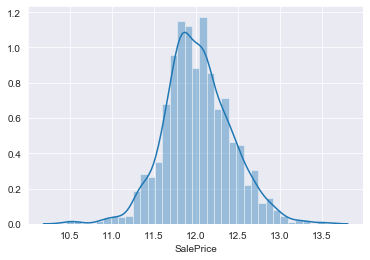

In [164]:
sns.distplot(y)

In [165]:
print('Train quantitative skewness')
skewed_features_train = []
for column in X[numerical_cols]:
    skew = abs(X[column].skew())
    print('{:15}'.format(column), 
          'Skewness: {:05.2f}'.format(skew))
    if skew > 0.75:
        skewed_features_train.append(column)

Train quantitative skewness
BedroomAbvGr    Skewness: 00.21
LowQualFinSF    Skewness: 08.99
KitchenAbvGr    Skewness: 04.48
GarageCars      Skewness: 00.36
OverallQual     Skewness: 00.20
YearBuilt       Skewness: 00.61
LotArea         Skewness: 12.63
MiscVal         Skewness: 24.46
Age             Skewness: 00.50
Fireplaces      Skewness: 00.63
TotalBtrm       Skewness: 00.25
ScreenPorch     Skewness: 04.11
LotFrontage     Skewness: 01.56
EnclosedPorch   Skewness: 03.08
3SsnPorch       Skewness: 10.28
WoodDeckSF      Skewness: 01.55
OpenPorchSF     Skewness: 02.34
PoolArea        Skewness: 15.93
OverallCond     Skewness: 00.69
TotalSF         Skewness: 00.82
MasVnrArea      Skewness: 02.71
GarageYrBlt     Skewness: 00.69


In [166]:
skewed_features_train

['LowQualFinSF',
 'KitchenAbvGr',
 'LotArea',
 'MiscVal',
 'ScreenPorch',
 'LotFrontage',
 'EnclosedPorch',
 '3SsnPorch',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea',
 'TotalSF',
 'MasVnrArea']

In [167]:
lam = 0.15
for feat in skewed_features_train:
    X[feat] = boxcox1p(X[feat], lam)

In [168]:
print('Test quantitative skewness')
skewed_features_test = []
for column in test_data_X[numerical_cols]:
    skew = abs(test_data_X[column].skew())
    print('{:15}'.format(column), 
          'Skewness: {:05.2f}'.format(skew))
    if skew > 0.75:
        skewed_features_test.append(column)

Test quantitative skewness
BedroomAbvGr    Skewness: 00.44
LowQualFinSF    Skewness: 16.17
KitchenAbvGr    Skewness: 04.08
GarageCars      Skewness: 00.11
OverallQual     Skewness: 00.18
YearBuilt       Skewness: 00.59
LotArea         Skewness: 03.12
MiscVal         Skewness: 20.08
Age             Skewness: 00.40
Fireplaces      Skewness: 00.82
TotalBtrm       Skewness: 00.68
ScreenPorch     Skewness: 03.79
LotFrontage     Skewness: 00.62
EnclosedPorch   Skewness: 04.67
3SsnPorch       Skewness: 12.52
WoodDeckSF      Skewness: 02.13
OpenPorchSF     Skewness: 02.69
PoolArea        Skewness: 20.20
OverallCond     Skewness: 00.45
TotalSF         Skewness: 01.20
MasVnrArea      Skewness: 02.55
GarageYrBlt     Skewness: 00.69


In [169]:
skewed_features_test

['LowQualFinSF',
 'KitchenAbvGr',
 'LotArea',
 'MiscVal',
 'Fireplaces',
 'ScreenPorch',
 'EnclosedPorch',
 '3SsnPorch',
 'WoodDeckSF',
 'OpenPorchSF',
 'PoolArea',
 'TotalSF',
 'MasVnrArea']

In [170]:
lam = 0.15
for feat in skewed_features_test:
    test_data_X[feat] = boxcox1p(test_data_X[feat], lam)

C:\Users\tusha\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Scaling

In [171]:
scaling = StandardScaler()
X_numeric = pd.DataFrame(scaling.fit_transform(X[numerical_cols]),columns=numerical_cols)
test_data_X_numeric = pd.DataFrame(scaling.fit_transform(test_data_X[numerical_cols]),columns=numerical_cols)

In [172]:
cat_cols = X.select_dtypes(include='object').columns

### One hot encoding categorical data

In [173]:
df_onehot = pd.get_dummies(df[cat_cols], columns=cat_cols, drop_first=True)
df_onehot.head()
# df_onehot.shape

MSSubClass_150  MSSubClass_160  MSSubClass_180  MSSubClass_190  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   MSSubClass_20  MSSubClass_30  MSSubClass_40  MSSubClass_45  MSSubClass_50  \
0              0              0              0              0              0   
1              1              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   MSSubClass_60  MSSubClass_70  MSSubClass_75  MSSubClass_80  MSSubClass_85  \
0              1              0              0              0              0   
1              0              0              0              0              0   
2              1              0              0              0              0   
3              0              1              0              0              0   
4              1              0              0              0              0   

   MSSubClass_90  MSZoning_FV  MSZoning_RH  MSZoning_RL  MSZoning_RM  \
0              0            0            0            1            0   
1              0            0            0            1            0   
2              0            0            0            1            0   
3              0            0            0            1            0   
4              0            0            0            1            0   

   Street_Pave  Alley_NA  Alley_Pave  LandContour_HLS  LandContour_Low  \
0            1         1           0                0                0   
1            1         1           0                0                0   
2            1         1           0                0                0   
3            1         1           0                0                0   
4            1         1           0                0                0   

   LandContour_Lvl  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0                1                  0              0              0   
1                1                  0              1              0   
2                1                  0              0              0   
3                1                  0              0              0   
4                1                  0              1              0   

   LotConfig_Inside  Condition1_Feedr  Condition1_Norm  Condition1_PosA  \
0                 1                 0                1                0   
1                 0                 1                0                0   
2                 1                 0                1                0   
3                 0                 0                1                0   
4                 0                 0                1                0   

   Condition1_PosN  Condition1_RRAe  Condition1_RRAn  Condition1_RRNe  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   Condition1_RRNn  Condition2_Feedr  Condition2_Norm  Condition2_PosA  \
0                0                 0                1                0   
1                0                 0                1                0   
2                0                 0                1                0   
3                0                 0                1                0   
4                0                 0                1        

In [174]:
X_onehot = df_onehot.iloc[:df[~df['SalePrice'].isna()].shape[0]]
test_data_X_onehot = df_onehot.iloc[:df[df['SalePrice'].isna()].shape[0]]
print(X_onehot.shape)
print(test_data_X_onehot.shape)

(1454, 147)
(1459, 147)


#### Merging quantitative and qualitative data.

In [175]:
X_final = pd.concat([X_numeric, X[ordinal_features], X_onehot],axis=1).reset_index(drop=True)
X_final.shape

(1454, 192)

In [176]:
test_data_X_final = pd.concat([test_data_X_numeric.reset_index(drop=True), test_data_X[ordinal_features].reset_index(drop=True), test_data_X_onehot.reset_index(drop=True)],axis=1, )
test_data_X_final.shape

(1459, 192)

#### Remove columns with less than 10 ones in training dataset

In [177]:
few_ones_train = list((X_onehot.sum()[X_onehot.sum()<10]).index)
(few_ones_train)

['MSSubClass_150',
 'MSSubClass_40',
 'LotConfig_FR3',
 'Condition1_PosA',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Feedr',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'HouseStyle_2.5Fin',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_CBlock',
 'Exterior2nd_Other',
 'Exterior2nd_Stone',
 'Foundation_Stone',
 'Foundation_Wood',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Electrical_FuseP',
 'Electrical_Mix',
 'GarageType_CarPort',
 'MiscFeature_Othr',
 'MiscFeature_TenC',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_Oth',
 'SaleCondition_AdjLand']

In [178]:
X_final = X_final.drop(columns=few_ones_train)
test_data_X_final = test_data_X_final.drop(columns=few_ones_train)


In [179]:
print(X_final.shape)
print(test_data_X_final.shape)

(1454, 145)
(1459, 145)


### Train-Test Split

In [180]:
X_train, X_test, Y_train, Y_test = train_test_split(X_final, y, test_size = .3, random_state=0)

### RMSE Evaluation

In [181]:
def rmse(actual,predicted):
    return(str(np.sqrt(metrics.mean_squared_error(actual, predicted))))

# Modeling

We will now try to build various Regression models, and evaluate their performances

 ## Simple Linear Regression without regularization

In [182]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)

y_pred_train = lin_reg.predict(X_train)
y_pred_test = lin_reg.predict(X_test)

print('RMSE train = ' + rmse(Y_train,y_pred_train))
print('RMSE test = ' + rmse(Y_test,y_pred_test)) 


lin_reg.fit(X_final, y)
y_pred = lin_reg.predict(X_final)
print('RMSE of entire train dataset = ' + rmse(y,y_pred))

RMSE train = 0.10147791813773455
RMSE test = 0.12454766928070066
RMSE of entire train dataset = 0.10357208992773918


In [183]:
# (y_pred_test-Y_test).sort_values(ascending=False)

In [184]:
# (y_pred_test-Y_test).shape

# Lasso Regression (L1 regularization)

In [185]:
lasso_reg =Lasso()
parameters= {'alpha': [0.0005,0.001,0.1,1,5,10,20]}

lasso_reg=GridSearchCV(lasso_reg, param_grid=parameters)
lasso_reg.fit(X_final,y)
alpha = lasso_reg.best_params_
lasso_score = lasso_reg.best_score_
print("The best alpha value found is:",alpha['alpha'],'with score:',lasso_score)

lasso_reg_alpha = Lasso(alpha=alpha['alpha'])
lasso_reg_alpha.fit(X_train, Y_train)
y_pred_train=lasso_reg_alpha.predict(X_train)
y_pred_test=lasso_reg_alpha.predict(X_test)

print('RMSE train = ' + rmse(Y_train,y_pred_train))
print('RMSE test = ' + rmse(Y_test,y_pred_test))

lasso_reg_alpha.fit(X_final, y)
y_pred = lasso_reg_alpha.predict(X_final)
print('RMSE of entire train dataset = ' + rmse(y,y_pred))

The best alpha value found is: 0.001 with score: 0.9121433126285898
RMSE train = 0.11041331285882557
RMSE test = 0.11741425132202062
RMSE of entire train dataset = 0.11158151380367307


## Ridge Regression (L2 regularization)

In [186]:
ridge=Ridge()
parameters= {'alpha': [0.0005,0.001,0.1,0.2,0.4,0.5,0.7,0.8,1]}

ridge_reg=GridSearchCV(ridge, param_grid=parameters)
ridge_reg.fit(X_final,y)
alpha = ridge_reg.best_params_
ridge_score = ridge_reg.best_score_
print("The best alpha value found is:",alpha['alpha'],'with score:',ridge_score)

ridge_reg_alpha=Ridge(alpha=alpha['alpha'])
ridge_reg_alpha.fit(X_train, Y_train)
y_pred_train=ridge_reg_alpha.predict(X_train)
y_pred_test=ridge_reg_alpha.predict(X_test)

print('RMSE train = ' + rmse(Y_train,y_pred_train))
print('RMSE test = ' + rmse(Y_test,y_pred_test))


ridge_reg_alpha.fit(X_final, y)
y_pred = ridge_reg_alpha.predict(X_final)
print('RMSE of entire train dataset = ' + rmse(y,y_pred))

The best alpha value found is: 1 with score: 0.908040364827117
RMSE train = 0.10260390806275431
RMSE test = 0.11864727386260909
RMSE of entire train dataset = 0.10410618670266658


## Random Forest Regressor

In [187]:
rf_reg = RandomForestRegressor()
parameters = {"max_depth":[5, 8, 15, 25, 30], "n_estimators":[25,50,100,200]}

rf_reg_param = GridSearchCV(rf_reg, parameters, cv = 10, n_jobs =10)
rf_reg_param.fit(X_train, Y_train)
rf_reg_best=rf_reg_param.best_estimator_
y_pred_train = rf_reg_best.predict(X_train)
y_pred_test = rf_reg_best.predict(X_test)

print('RMSE train = ' + rmse(Y_train,y_pred_train))
print('RMSE test = ' + rmse(Y_test,y_pred_test))

rf_reg_param.fit(X_final, y)
y_pred = rf_reg_param.predict(X_final)
print('RMSE of entire train dataset = ' + rmse(y,y_pred))

RMSE train = 0.05057659003879571
RMSE test = 0.1384307988663117
RMSE of entire train dataset = 0.04995916721212157


## XGBoost Regressor

In [188]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000)
xgb_reg.fit(X_train, Y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, Y_test)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [189]:
xgb_reg_param = xgb.XGBRegressor(learning_rate=0.05,
                      n_estimators=1000,
                      max_depth=3)

xgb_reg_param.fit(X_train, Y_train)
xgb_train_pred = xgb_reg_param.predict(X_train)
xgb_test_pred = xgb_reg_param.predict(X_test)


print('RMSE train = ' + rmse(Y_train,xgb_train_pred))
print('RMSE test = ' + rmse(Y_test,xgb_test_pred))


xgb_reg_param.fit(X_final, y)
y_pred = xgb_reg_param.predict(X_final)
print('RMSE of entire train dataset = ' + rmse(y,y_pred))

RMSE train = 0.04047278092234625
RMSE test = 0.1261441248626569
RMSE of entire train dataset = 0.04831121463533177


## Blended approach
Using our best performing models, we can use a blended approach to further improve our results

In [190]:
def blended_regression(X):
    return ((0.3 * ridge_reg_alpha.predict(X)) + (0.7 * xgb_reg_param.predict(X)))

In [191]:
y_pred_train = blended_regression(X_train)
y_pred_test = blended_regression(X_test)
print('RMSE train = ' + rmse(Y_train,y_pred_train))
print('RMSE test = ' + rmse(Y_test,y_pred_test))

y_pred = blended_regression(X_final)
print('RMSE of entire train dataset = ' + rmse(y,y_pred))

RMSE train = 0.06135353718687512
RMSE test = 0.05935128812413561
RMSE of entire train dataset = 0.06075869661088743


## Submission

In [192]:
y_test=blended_regression(test_data_X_final)

In [193]:
final_y_test=np.expm1(y_test)

In [194]:
sample=pd.read_csv('sample_submission.csv')
submission=pd.DataFrame({"Id":sample['Id'],
                         "SalePrice":final_y_test})
submission.to_csv('submission.csv',index=False)